# TP 3 : LINEAR REGRESSION

## EXERCICE 1 : Le jeu de données contaminé par le robot 

In [169]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import r2_score
from pylab import pcolor, show, colorbar, xticks, yticks
import statsmodels.api as sm
import seaborn as sns

### Question 1

Importer la base de données data_dm3.csv disponible depuis le lien https://bitbucket.org/
portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer.
Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives
et le nombre d’observations.

In [2]:
data = pd.read_csv("https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv", sep = ",", header = None)

In [3]:
explicated_var = pd.DataFrame(data.iloc[ : ,-1])
explicative_var = pd.DataFrame(data.drop(data.columns[-1], axis= 1))

In [4]:
print("Nombre d\'observations : ", explicative_var.shape[0], "\nNombre de variables explicatives : ", explicative_var.shape[1] )

Nombre d'observations :  442 
Nombre de variables explicatives :  210


### Question 2 

Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ?
Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à
expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des
autres). Commenter les graphiques obtenus.

In [5]:
eps = 10**(-4) # Set a eps to compare to 0
if (all(abs(explicative_var.mean()) < eps)):
    print('Explicative variables are centered')
else: 
    print('Explicative variables not centered')
    
if (all(explicative_var.var() - 1 < 10**-2)):
    print('Explicative variables are standardized')
else: 
    print('Explicative variables not standardized')


Explicative variables are centered
Explicative variables are standardized


In [6]:
eps = 10**(-4) # Set a eps to compare to 0
if (all(abs(explicated_var.mean()) < eps)):
    print('Explicated variable is centered')
else: 
    print('Explicated variable not centered')
    
if (all(explicated_var.var() - 1 < 10**-2)):
    print('Explicated variable is standardized')
else: 
    print('Explicated variable not standardized')


Explicated variable not centered
Explicated variable not standardized


<IPython.core.display.Javascript object>


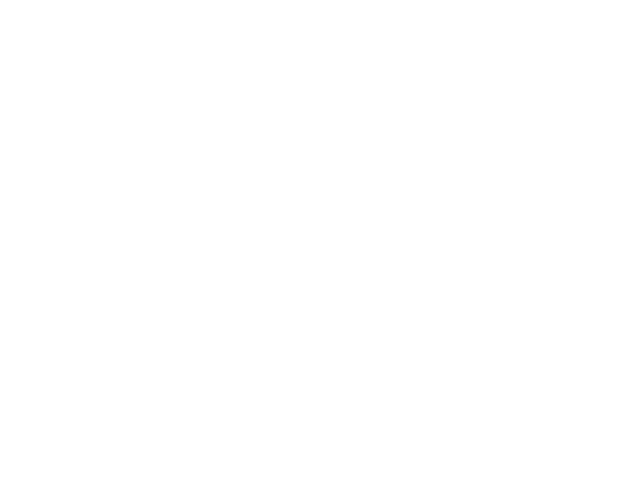

In [7]:
%matplotlib notebook
# Get 4 different columns randomly
random.seed(1234) # for reproducibility
rand_col = np.random.randint(0, len(explicative_var.columns), [4])
df_toplot = pd.concat([pd.DataFrame(explicative_var[rand_col]), explicated_var], axis = 1)
scatter_matrix(df_toplot)
plt.show()

Comment : from this scatterplot, which only represents 4 variables randomly selected in te 210 variables, there is no apparent correlation between variables, nor between the explicative variables and the explicated one.

### Question 3

Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle X train ,
un pour tester le modèle X test . On mettra 20% de la base dans l’échantillon ’test’. Donner les tailles
de chacun des 2 échantillons.

In [8]:
rnd_seed = 2
X_train, X_test, y_train, y_test = train_test_split(explicative_var, explicated_var, test_size = 0.20, random_state = rnd_seed)

In [9]:
# Get all to dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [10]:
# Get sample size :
n_test = X_test.shape[0]
n_train = X_train.shape[0]
print('Train sample is ', n_train, '\nTest sample is ', n_test)

Train sample is  353 
Test sample is  89


### Question 4 

Donner la matrice des correlations calculée sur X train . Tracer le graphe de la décroissance des
valeurs propres de la matrice de corrélation. Expliquer pourquoi il est légitime de ne garder que les
premières variables de l’ACP. On gardera 60 variables dans la suite.

In [11]:
# Correlation matrix
correlation = X_train.corr()
eigenval, eigenvect = np.linalg.eigh(correlation)

In [12]:
print('Nombre de valeurs propres non nulles', (sum(eigenval > eps)))

Nombre de valeurs propres non nulles 60


<IPython.core.display.Javascript object>


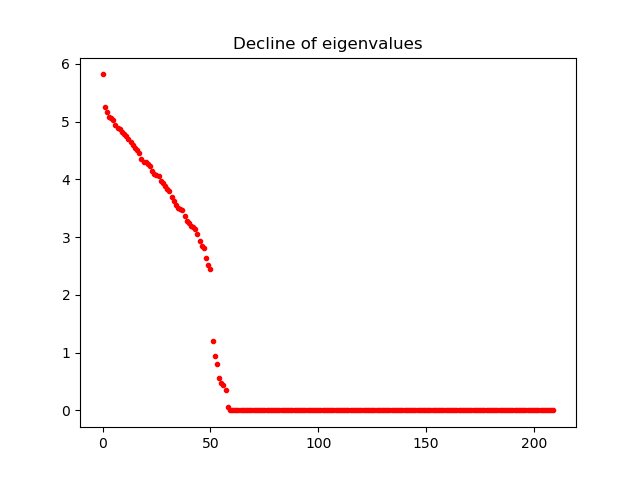

In [40]:
%matplotlib notebook
# Graph of eigenvalues
plt.figure()
plt.plot(sorted(eigenval, reverse = True), '.r')
plt.title('Decline of eigenvalues')
plt.show()

We observe that from the 60th eigenvalue, they are virtually equal to 0. Which means the last variables have no impact in the global variance. 
This fact justifies we keep 60 features for the analysis.

In [14]:
# ACP analysis
a = PCA(n_components=60)
X_new = pd.DataFrame(a.fit_transform(explicative_var))
X_new_train, X_new_test = train_test_split(X_new, test_size = 0.20, random_state = rnd_seed)

### Question 5

Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui
consiste à faire une ACP avant la régression. Faire une régression linéaire (avec intercept), puis
tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de même avec la
méthode des moindres carrés classique.

Intercept is  151.10230163738797


<IPython.core.display.Javascript object>


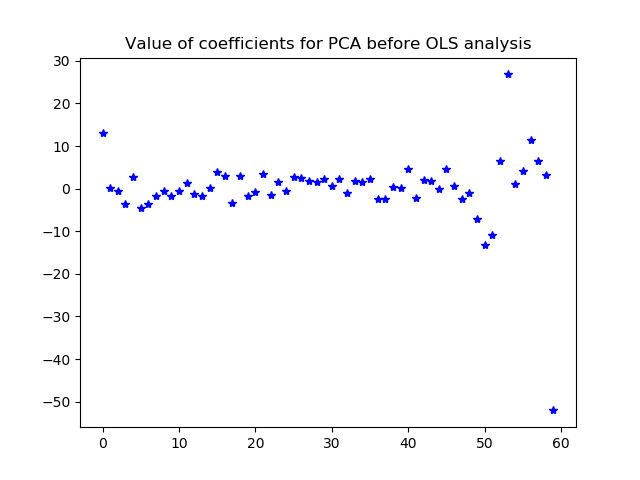

In [43]:
%matplotlib notebook
# PCA BEFORE OLS
reg_pca_before_ols = LinearRegression().fit(X_new_train, y_train)
plt.figure()
plt.plot(reg_pca_before_ols.coef_[0], 'b*')
plt.title('Value of coefficients for PCA before OLS analysis')
plt.show()

With classical OLS (all variables)

<IPython.core.display.Javascript object>


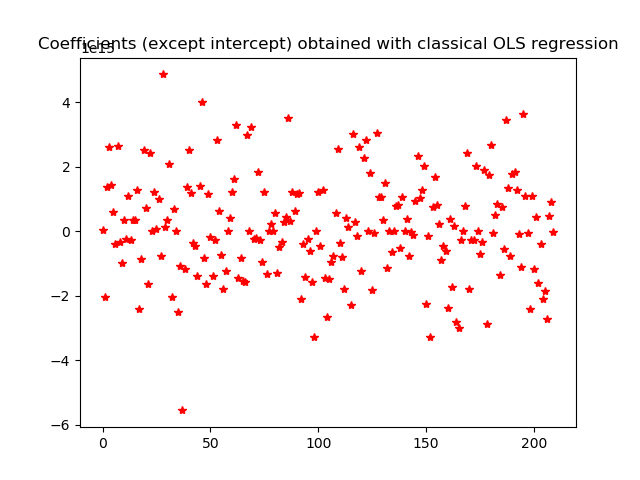

In [46]:
plt.figure()
reg_ols = LinearRegression().fit(pd.DataFrame(X_train), pd.DataFrame(y_train))
plt.plot(reg_ols.coef_[0], 'r*')
plt.title('Coefficients (except intercept) obtained with classical OLS regression')
plt.show()

### Question 6

Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur moyenne
de la variable Y (sur le train set). Les intercepts des 2 questions sont-ils égaux ? Commenter.
Uniquement pour cette question, centrer et réduire les variables après ACP (de petite dimension).
Faire une régression avec ces variables et vérifier que l’intercept est bien égal à la moyenne de Y
sut le train.

In [47]:
print("Intercept using PCA before OLS is ", reg_pca_before_ols.intercept_[0])
print("Intercept using OLS is ", reg_ols.intercept_[0])
print("Mean of y in train set is ", y_train[210].mean())

Intercept using PCA before OLS is  151.10230163738797
Intercept using OLS is  150.20892351274787
Mean of y in train set is  150.45892351274787


The two intercepts are similar but slightly different because one regression uses 60 explicative variables, the other 210. It means some explicative variables used in OLS regression reduce the impact of the intercept.
The intercepts are close to the mean of Y.

In [18]:
# Center and reduce ACP variables
ACP_normalized = preprocessing.scale(X_new_train)
reg_pca_norm = LinearRegression().fit(ACP_normalized, pd.DataFrame(y_train))
print("Intercept found is ", reg_pca_norm.intercept_[0]," and Y mean is ", y_train[210].mean())

Intercept found is  150.45892351274787  and Y mean is  150.45892351274787


The two values correspond. The intercept coresponds to the mean of the variable, an expected result with the explicative variables centered and not y.

### Question 7

Pour les 2 méthodes (OLS et PCA before OLS) : Tracer les résidus de la prédiction sur l’échantillon
test. Tracer leur densité (on pourra par exemple utiliser un histogramme). Calculer le coefficient de
détermination sur l’échantillon test. Calculer le risque de prédiction sur l’échantillon test.

<IPython.core.display.Javascript object>


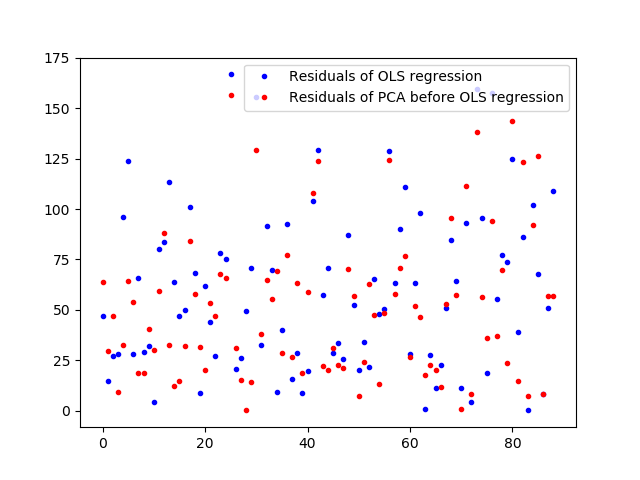

In [81]:
# OLS
predictions_OLS = reg_ols.predict(X_test)
residuals_OLS = predictions_OLS - y_test
# PCA before OLS
predictions_PCA_OLS = reg_pca_before_ols.predict(X_new_test)
residuals_PCA_OLS = predictions_PCA_OLS - y_test
plt.figure()
plt.rc("legend", fontsize=10)
plt.plot(range(len(residuals_OLS)), abs(residuals_OLS), 'b.', label = 'Residuals of OLS regression')
plt.plot(range(len(residuals_PCA_OLS)), abs(residuals_PCA_OLS), 'r.', label = 'Residuals of PCA before OLS regression')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


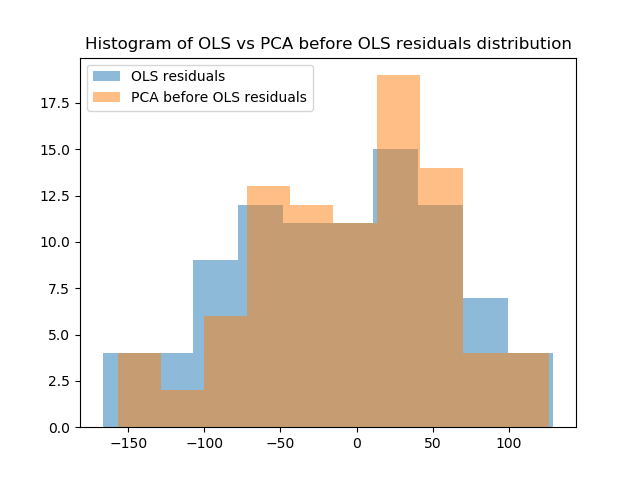

In [58]:
plt.figure()
plt.hist(residuals_OLS[210], alpha = 0.5, label = 'OLS residuals')
plt.hist(residuals_PCA_OLS[210], alpha = 0.5, label = 'PCA before OLS residuals')
plt.title('Histogram of OLS vs PCA before OLS residuals distribution')
plt.legend()
plt.show()

In [60]:
# Coefficient de détermination
print('Determination coefficient with OLS : ', r2_score(y_test, predictions_OLS))
print('Detemrination coefficient with PCA before OLS : ', r2_score(y_test, predictions_PCA_OLS))

Determination coefficient with OLS :  0.06718543973672164
Detemrination coefficient with PCA before OLS :  0.2925870596657737


Formula used to compute prediction risk (according to slides)
$$ R_{pred} = \frac {rank(X)}{n} \sigma^2 $$

We estimate residual variance as usual :
$$ \hat{\sigma}^2 = \frac {\sum_{i=1}^{n}\hat{\epsilon}^2} {n - rank(X)} $$

In [167]:
# Prediction risk
# a. OLS model
n_test = len(X_test)
SSR_OLS = (residuals_OLS ** 2).sum()
rank_OLS_X = np.linalg.matrix_rank(X_test) + 1 # with intercept (note that X is not full rank, has rank = 60)
residual_variance_OLS = SSR_OLS / (n_test - rank_OLS_X)
prediction_risk_OLS = residual_variance_OLS * rank_OLS_X / n_test
prediction_risk_OLS = prediction_risk_OLS[210]
print('Prediction risk for OLS : ', prediction_risk_OLS)

Prediction risk for OLS :  11228.253616582684


In [165]:
# b. PCA before OLS model
n_test = len(X_test)
SSR_PCA_OLS = (residuals_PCA_OLS ** 2).sum()
rank_PCA_OLS_X = np.linalg.matrix_rank(X_new_test) + 1 # with intercept (note that X is not full rank, has rank = 60)
residual_variance_PCA_OLS = SSR_PCA_OLS / (n_test - rank_PCA_OLS_X)
prediction_risk_PCA_OLS = residual_variance_PCA_OLS * rank_PCA_OLS_X / n_test
prediction_risk_PCA_OLS = prediction_risk_PCA_OLS[210]
print('Prection risk for PCA before OLS : ', prediction_risk_PCA_OLS)

Prection risk for PCA before OLS :  8515.102834033085


### Question 8 

Appliquer la méthode de forward variable sélection. On pourra utiliser la statistique du test de
nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arret sur la
méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver la totalité des
variables. Afficher l’ordre de séléction des variables.

Algo : 
- On régresse sur chaque variable les unes après les autres. 
- On garde celle avec la p value la plus haute.
- On recommence avec les résidus de cette première regression.

In [112]:
def variable_selection(X, y):
    """
    Given X a matrix of explicative variables not including a constant and y a vector
    Computes the pvalues for all regression with one parameter and returns the X feature giving the lowest p-value
    Returns the pvalue and the index of the selected variable
    """
    l_pval = 1
    for i in range(X.shape[1]):
        X_feature = sm.add_constant(X.iloc[:,i])
        lin_mod = sm.OLS(y, pd.DataFrame(X_feature), hasconst = True).fit()
        pval = lin_mod.pvalues[1]
        if pval < l_pval:
            l_pval = pval
            index = X.iloc[:,i].name
    return l_pval, index, lin_mod.resid

In [113]:
def variable_selection_detailed(X,y):
    """
    Given X a matrix of explicative variables not including a constant and y a vector
    Computes the pvalues for all regression with one parameter and returns the X feature giving the lowest p-value
    Returns the pvalues, t stats and index of all tested variables
    """
    t_stats = []
    index_for_disp = []
    p_val_total = []
    l_pval = 1
    for i in range(X.shape[1]):
        X_feature = sm.add_constant(X.iloc[:,i])
        lin_mod = sm.OLS(y, pd.DataFrame(X_feature), hasconst = True).fit()
        pval = lin_mod.pvalues[1]
        if pval < l_pval:
            l_pval = pval
            index = X.iloc[:,i].name
        t_stats.append(lin_mod.tvalues[1])
        p_val_total.append(lin_mod.pvalues[1])
        index_for_disp.append(X.iloc[:,i].name)
    return index_for_disp, t_stats, p_val_total

In [114]:
X_feat = X_train
index_keep = []
dicotest = dict()
pval_keep = []
resid_temp = y_train
for j in range(X_train.shape[1]):
    l_pval, index, residuals = variable_selection(X_feat, resid_temp)
    dicotest[index] = l_pval
    index_keep.append(index)
    pval_keep.append(l_pval)
    X_feat = X_feat.drop(columns = index)
    resid_temp = residuals

In [115]:
print('Ordre de sélection des variables : ', index_keep)

Ordre de sléection des variables :  [58, 123, 167, 34, 174, 23, 99, 133, 79, 49, 168, 159, 162, 112, 43, 17, 85, 129, 84, 152, 111, 103, 182, 22, 53, 47, 104, 27, 172, 154, 131, 177, 127, 208, 30, 203, 98, 18, 148, 181, 76, 94, 96, 29, 20, 206, 173, 11, 5, 147, 176, 13, 33, 83, 142, 54, 8, 80, 77, 200, 141, 24, 82, 189, 169, 207, 190, 73, 121, 32, 37, 119, 151, 180, 132, 9, 52, 36, 135, 158, 28, 31, 72, 204, 63, 134, 197, 196, 156, 130, 185, 118, 69, 155, 184, 41, 115, 93, 78, 89, 45, 117, 19, 175, 25, 2, 87, 86, 4, 35, 0, 201, 61, 44, 113, 157, 138, 187, 107, 202, 150, 48, 50, 26, 90, 153, 171, 66, 110, 120, 199, 136, 193, 146, 62, 39, 105, 74, 12, 55, 15, 124, 163, 149, 57, 16, 71, 198, 38, 183, 1, 186, 51, 42, 137, 59, 7, 145, 125, 46, 100, 106, 188, 102, 191, 116, 92, 91, 88, 192, 178, 108, 114, 143, 205, 3, 101, 139, 161, 164, 14, 122, 95, 75, 60, 126, 64, 97, 81, 40, 128, 194, 195, 70, 68, 56, 65, 160, 6, 144, 165, 67, 179, 170, 166, 140, 109, 10, 21, 209]


### Question 9 

Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode en donnant
(i) les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme et 3eme variables (en
abscisse : l’index des variables, en ordonné : la valeur des stats) , (ii) le graphe des 50 premières
p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la
ligne horizontale d’ordonnée 0.1. Enfin on donnera la liste des variables sélectionnées.

In [138]:
# STOP WHEN PVAL > 0.1
# We already have results stored from previous question
stop_criteria = dict( (key, value) for (key, value) in dicotest.items() if value < 0.1 )

In [139]:
print('nombre de variables : ', len(stop_criteria))
print(stop_criteria)

nombre de variables :  37
{58: 4.004899789759472e-35, 123: 1.4583743205385477e-33, 167: 1.3856949985794188e-19, 34: 3.415754136619503e-17, 174: 2.589791670367082e-14, 23: 3.2147553310499264e-12, 99: 1.818600440760095e-05, 133: 2.7966693764175946e-05, 79: 0.0005770468048153153, 49: 0.000935483627059105, 168: 0.003069420857819324, 159: 0.004227934610461127, 162: 0.006321524726514395, 112: 0.009885811954683672, 43: 0.013860028669887203, 17: 0.025104529498878227, 85: 0.04001576794736752, 129: 0.04231749354427817, 84: 0.04305346403716137, 152: 0.04331583275244827, 111: 0.044295765000967206, 103: 0.053185979403449, 182: 0.05465220470352772, 22: 0.05554203688014536, 53: 0.05685827095189839, 47: 0.061124410805667086, 104: 0.06321531218559212, 27: 0.06512147107223695, 172: 0.06667397647346054, 154: 0.06905699073574115, 131: 0.07302191848913503, 177: 0.07798749728155305, 127: 0.08091183601619412, 208: 0.0813948737077624, 30: 0.08202831119076832, 203: 0.09375555303683396, 98: 0.095250298128853}


(i) Graphs of statistics obtained with selection of the first, second and third variable

In [140]:
# First variable selection
indices, tstats, pvals = variable_selection_detailed(X_train, y_train)

<IPython.core.display.Javascript object>


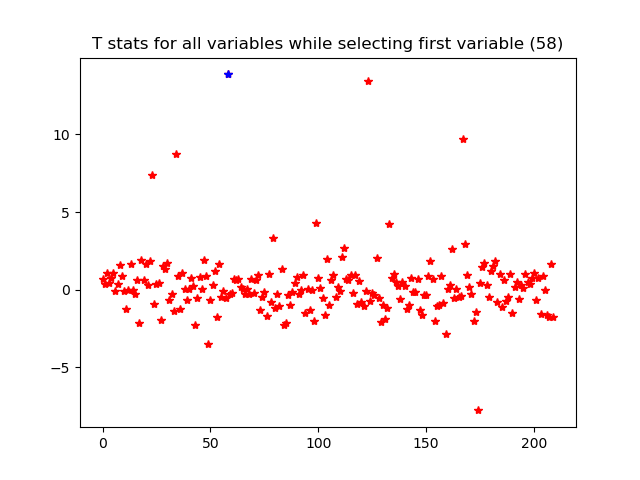

In [134]:
plt.figure()
plt.plot(indices, tstats, 'r*')
plt.title('T stats for all variables while selecting first variable (58)')
plt.plot(58, tstats[58], 'b*')
plt.show()

<IPython.core.display.Javascript object>


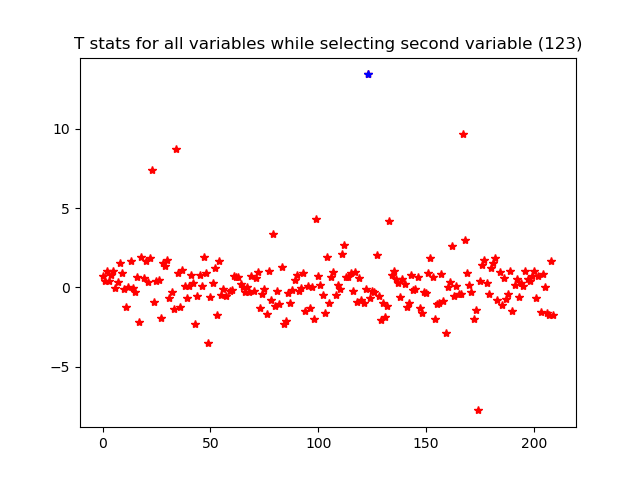

In [135]:
# Second variable selection
variable_to_drop = [indices[tstats.index(max(np.abs(tstats)))]]
indices, tstats, pvals = variable_selection_detailed(X_train.drop(columns = variable_to_drop), y_train)
plt.figure()
plt.plot(indices, tstats, 'r*')
plt.plot(indices[tstats.index(max(np.abs(tstats)))], tstats[tstats.index(max(np.abs(tstats)))], 'b*')
plt.title('T stats for all variables while selecting second variable (123)')
plt.show()

<IPython.core.display.Javascript object>


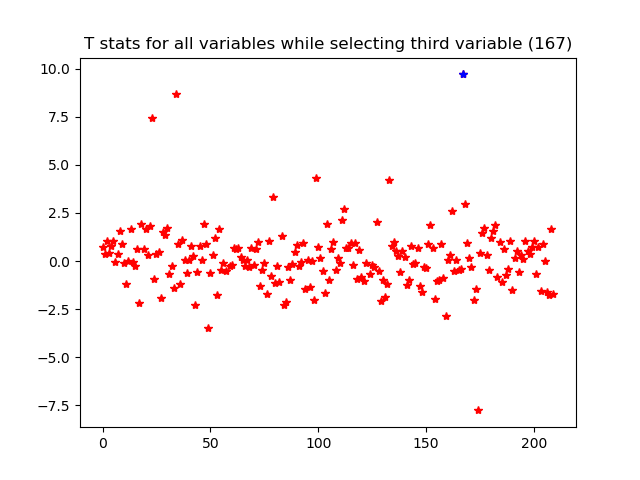

In [136]:
# Third variable selection
variable_to_drop.append(indices[tstats.index(max(np.abs(tstats)))])
indices, tstats, pvals = variable_selection_detailed(X_train.drop(columns = variable_to_drop), y_train)
plt.figure()
plt.plot(indices, tstats, 'r*')
plt.plot(indices[tstats.index(max(np.abs(tstats)))], tstats[tstats.index(max(np.abs(tstats)))], 'b*')
plt.title('T stats for all variables while selecting third variable (167)')
plt.show()

(ii) First p-values graph

<IPython.core.display.Javascript object>


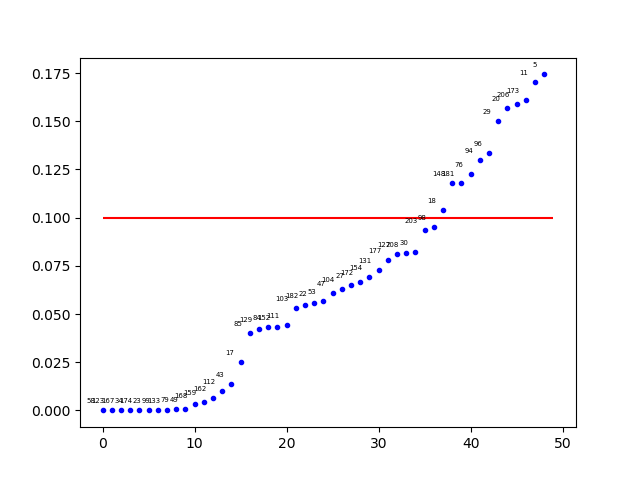

In [141]:
x = range(49)
y = pval_keep[0:49]
z = index_keep[0:49]
plt.rc("legend", fontsize=1)

fig, ax = plt.subplots()
ax.plot(x, y, 'b.')
ax.hlines(y=0.1, xmin=0, xmax=49, color='r')
for X, Y, Z in zip(x, y, z):
    ax.annotate('{}'.format(Z), xy=(X,Y), xytext = (-5, 5), ha='right',
                textcoords='offset points', size = 5)

plt.show()


In [142]:
# Liste des variables sélectionnées
features_to_keep = []
for i in range(len(pval_keep)):
    if pval_keep[i] < 0.1:
        features_to_keep.append(index_keep[i])
print('Features to keep are : ',features_to_keep, '\nNumber of features : ', len(features_to_keep))

Features to keep are :  [58, 123, 167, 34, 174, 23, 99, 133, 79, 49, 168, 159, 162, 112, 43, 17, 85, 129, 84, 152, 111, 103, 182, 22, 53, 47, 104, 27, 172, 154, 131, 177, 127, 208, 30, 203, 98] 
Number of features :  37


### Question 10 

Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction sur obtenu l’échantillon
test et le comparer à ceux de OLS et PCA before OLS.

In [160]:
# Generate new dataframe only with selected features
forward_var_selected_train = pd.DataFrame(data = X_train[features_to_keep])
forward_var_selected_test = pd.DataFrame(data = X_test[features_to_keep])
# Apply OLS on train set
ols_selected = sm.OLS(y_train, sm.add_constant(forward_var_selected_train), hasconst = True).fit()
# Make predictions on test set
predictions_OLS_selected = ols_selected.predict(sm.add_constant(forward_var_selected_test))
residuals_selected_test = y_test[210] - predictions_OLS_selected
# Compute prediction risk
SSR_selected_OLS = (residuals_selected_test ** 2).sum()
rank_selected_OLS = np.linalg.matrix_rank(forward_var_selected_test) + 1
residual_variance_selected_OLS = SSR_selected_OLS / (n_test - rank_selected_OLS)
prediction_risk_OLS_selected_test = residual_variance_selected_OLS * rank_selected_OLS / n_test
print('Prediction risk for selected OLS : ', prediction_risk_OLS_selected_test)

Prediction risk for selected OLS :  2953.9609933733036


In [168]:
# Summary of results as of prediction risk
data_rpred = {'OLS with all features': [prediction_risk_OLS],
                    'PCA before OLS': [prediction_risk_PCA_OLS],
                    'OLS with forward variable selection':[prediction_risk_OLS_selected_test]
                                    }
results_rpred = pd.DataFrame(data = data_rpred)
results_rpred

,OLS with all features,PCA before OLS,OLS with forward variable selection
0,11228.253617,8515.102834,2953.960993


We see that forward variable selection seriously improves the prediction risk. This is
- Mechanical since the risk is proportional to the number of features used (37 vs 60)

### Question 11 

Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées ”folds”) de
façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque fold.

In [181]:
kf = KFold(n_splits=4, shuffle=True, random_state=rnd_seed)
for k, (train, test) in enumerate(kf.split(X_train, y_train)):
    print('Fold ', k, ' ', test)


Fold  0   [  3   7  10  12  13  17  20  24  25  29  30  35  41  55  60  65  66  67
  68  69  70  77  84  89  94  98  99 100 112 114 126 128 131 142 146 147
 150 151 152 153 156 157 160 161 163 169 172 174 180 188 189 192 199 206
 210 215 216 217 223 225 227 230 232 234 236 240 241 244 251 257 262 264
 268 269 276 285 291 298 305 306 308 320 325 340 341 342 345 346 351]
Fold  1   [  2   4   5   6  11  14  18  23  28  39  44  53  54  64  71  74  79  85
  87  91  93 101 103 104 106 109 113 115 117 118 120 127 130 133 134 140
 141 144 154 155 166 170 173 175 176 178 179 181 182 183 184 186 190 194
 198 200 203 204 205 209 212 214 220 237 243 261 265 270 272 275 278 281
 284 286 292 294 296 300 303 310 314 317 328 329 331 336 337 339]
Fold  2   [  0   1   8   9  21  27  32  36  37  40  42  45  46  48  57  62  63  78
  82  90  92 105 107 108 110 111 119 122 129 135 139 145 159 164 165 171
 191 193 197 201 219 221 222 226 228 231 235 242 245 249 253 256 258 259
 266 267 273 274 277 279 280 28

### Question 12 

Appliquer la méthode de la régression ridge. Pour le choix du paramètre de régularisation, on fera
une validation croisée sur les ”folds” définies lors de la question précédente. A tour de rôle chacune
des ”folds” servira pour calculer le risque de prédiction alors que les autres seront utilisées pour
estimer le modèle. On moyennera ensuite les 4 risques de prédictions. On donnera la courbe du
risque de validation croisée en fonction du paramètre de régularisation (on veillera à bien choisir
l’espace de définition pour le graphe). Donner le paramètre de régularisation optimal et la valeur
du risque sur le test.

### Question 13 

A l’aide de la fonction lassoCV de sklearn, choisir le paramètre de régularisation du LASSO. Donner
le risque de prédiction associé.

### Question 14 

Donner les variables selectionées par le lasso. Combien y-en a t-il ? Appliquer la méthode OLS aux
variables sélectionnées. Cette méthode est appelé Least-square LASSO.

### Question 15 

Cette dernière question est un question d’ouverture vers une approche non-linéaire. En utilisant les
variables séléctionées par le LASSO (Q13) ou par la méthode forward (Q9), mettre au point une
méthode de regression non-linéaire. On apprendra les différents paramètres par validation croisée
et l’on donnera la valeur du risque de prédiction calculé sur l’échantillon test. Des performances
moindres par rapport à OLS peuvent se produire. Commenter.